This is an in-depth look into how the posterior predictions of LCEGP change when
training hyper-parameters.

Let's start by defining a ground truth model and some utilities for plotting /
evaluating the predictive posterior.

In [1]:
from typing import Union, List
from time import sleep

import torch
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from gpytorch import ExactMarginalLogLikelihood
from torch import Tensor

from contextual_rs.generalized_pcs import estimate_current_generalized_pcs
from contextual_rs.models.custom_fit import custom_fit_gpytorch_model
from contextual_rs.models.lce_gp import LCEGP

%matplotlib inline
import matplotlib.pyplot as plt


ckwargs = {"dtype": torch.double, "device": "cpu"}


class GroundTruthModel:
    def __init__(
        self,
        num_arms: int,
        context_map: Tensor,
        num_init_samples: int = None,
        init_scale: float = 50.0,
        observation_noise: float = 3.0,
    ):
        r"""
        Generate a GP model for use as the ground truth for function evaluations.
        The dimension is inferred from context_map, as context_map.shape[-1] + 1.
        """
        self.num_arms = num_arms
        self.arm_map = torch.linspace(0, 1, num_arms).view(-1, 1).to(context_map)
        self.context_map = context_map
        self.dim = context_map.shape[-1] + 1
        num_init_samples = num_init_samples or self.dim * 10
        train_X = torch.rand(num_init_samples, self.dim).to(context_map)
        train_Y = torch.randn(num_init_samples, 1).to(context_map) * init_scale
        self.model = SingleTaskGP(train_X, train_Y, outcome_transform=Standardize(m=1))
        self.observation_noise = observation_noise

    def evaluate_true(self, arm_idx: Union[List, int], context: Tensor) -> Tensor:
        r"""
        Evaluate the posterior mean at the given arm and context.
        If arm is int, context should be `1 x d` tensor.
        If arm is a list of size n, context should be `n x d` tensor.
        Returns a `n x 1`-dim tensor.
        """
        arms = self.arm_map[arm_idx].view(-1, 1)
        X = torch.cat([arms, context], dim=-1)
        return self.model.posterior(X).mean.view(-1, 1).detach()

    def evaluate(self, arm_idx: Union[List, int], context: Tensor) -> Tensor:
        true_evals = self.evaluate_true(arm_idx, context)
        return true_evals + torch.randn_like(true_evals) * self.observation_noise

    def evaluate_w_index(
        self, arm_idx: Union[List, int], context_idx: Union[List, int]
    ) -> Tensor:
        context = torch.atleast_2d(self.context_map[context_idx])
        return self.evaluate(arm_idx, context)

    def evaluate_all_true(self):
        r"""
        Evaluates all arm-context pairs without noise.
        """
        X = torch.cat(
            [
                self.arm_map.view(-1, 1, 1).repeat(1, self.context_map.shape[0], 1),
                self.context_map.repeat(self.num_arms, 1, 1),
            ],
            dim=-1,
        ).view(-1, self.dim)
        return self.model.posterior(X).mean.view(-1, 1).detach()

    def evaluate_all(self):
        true_evals = self.evaluate_all_true()
        return true_evals + torch.randn_like(true_evals) * self.observation_noise


def plot_posterior(
    model,
    arm_set: Tensor,
    context_set: Tensor,
    shade=True
) -> None:
    assert arm_set.dim() == context_set.dim() == 2
    assert context_set.shape[-1] == 1, "needed for plotting"
    # X is arms x contexts x d
    X = torch.cat(
        [
            arm_set.view(-1, 1, 1).expand(-1, context_set.shape[0], 1),
            context_set.unsqueeze(0).expand(arm_set.shape[0], -1, -1)
        ], dim=-1
    )
    post = model.posterior(X)
    pm = post.mean.detach()
    pstd = post.variance.detach().sqrt()

    fig = plt.figure(figsize=(12, 8))
    fig.patch.set_facecolor('xkcd:mint green')
    for arm_idx in range(arm_set.shape[0]):
        plt.plot(context_set.view(-1), pm[arm_idx].view(-1), label=str(arm_idx))
        if shade:
            plt.fill_between(
                context_set.view(-1),
                (pm[arm_idx] + pstd[arm_idx]).view(-1),
                (pm[arm_idx] - pstd[arm_idx]).view(-1),
                alpha=0.5
            )
    plt.grid()
    plt.show()


def get_pcs(model, arm_set, context_set) -> Tensor:
    return estimate_current_generalized_pcs(
        model=model,
        arm_set=arm_set,
        context_set=context_set,
        num_samples=256,
        base_samples=None,
        func_I=lambda X: (X > 0).to(**ckwargs),
        rho=lambda X: X.mean(dim=-2),
    )


def fit_lcegp(X, Y, num_tries: int = 1):
    lcegp = LCEGP(X, Y, categorical_cols=[0], outcome_transform=Standardize(m=1))
    mll = ExactMarginalLogLikelihood(lcegp.likelihood, lcegp)
    custom_fit_gpytorch_model(mll, num_retries=num_tries)
    return lcegp


Generate the ground truth and plot the function.

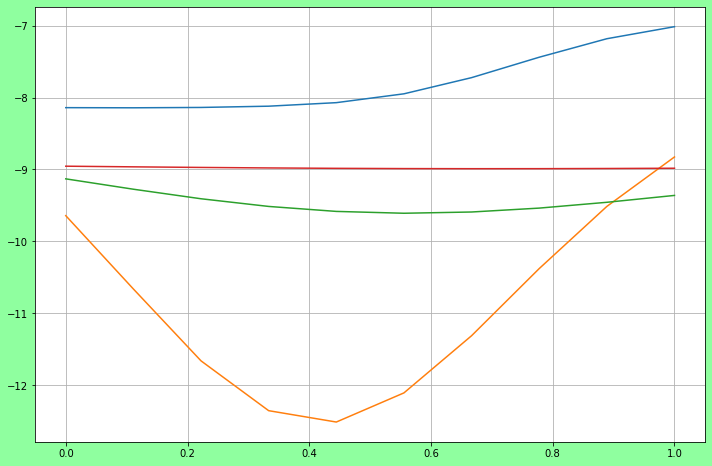

In [2]:
torch.manual_seed(30)

num_arms = 4
num_contexts = 10
arm_set = torch.arange(0, num_arms, **ckwargs).view(-1, 1)
context_map = torch.linspace(0, 1, num_contexts, **ckwargs).view(-1, 1)

ground_truth = GroundTruthModel(
    num_arms=num_arms, context_map=context_map, init_scale=20.0, observation_noise=1.5
)

plot_posterior(ground_truth.model, arm_set, context_map, shade=False)

Fit LCEGP on full observations for training and plot the resulting posterior.

/home/saitcakmak/anaconda3/envs/contextual_rs/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


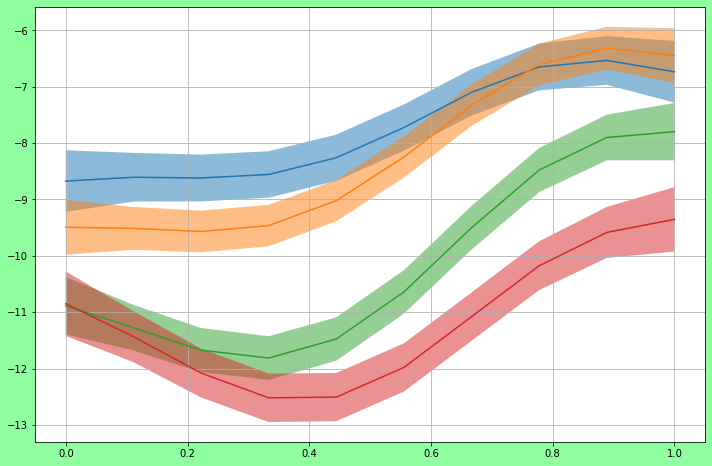

PCS estimate: 0.864453125


In [3]:
num_full_train = 3
train_X = (
    torch.cat(
        [
            arm_set.view(-1, 1, 1).expand(-1, num_contexts, -1),
            context_map.expand(num_arms, -1, -1),
        ],
        dim=-1,
    )
    .view(-1, 2)
    .repeat(num_full_train, 1)
)
train_Y = torch.cat(
    [ground_truth.evaluate_all() for _ in range(num_full_train)], dim=0
)

lcegp = fit_lcegp(train_X, train_Y)

plot_posterior(lcegp, arm_set, context_map)
print(f"PCS estimate: {get_pcs(lcegp, arm_set, context_map)}")

Now do the same, adding a random assortment of observations between each plot.

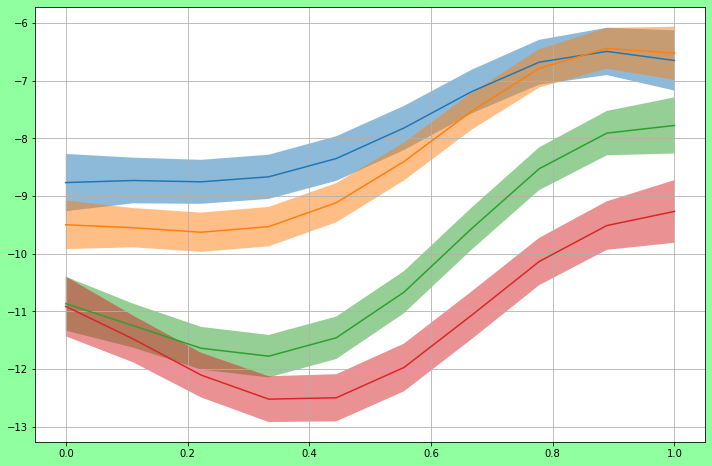

PCS estimate: 0.870703125
PCS estimate: 0.87734375
PCS estimate: 0.80390625
PCS estimate: 0.9
PCS estimate: 0.91796875
PCS estimate: 0.913671875
PCS estimate: 0.858984375
PCS estimate: 0.916015625
PCS estimate: 0.928125
PCS estimate: 0.910546875


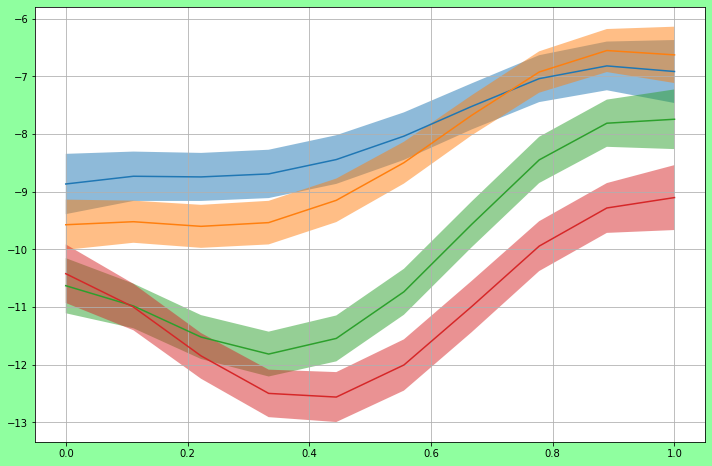

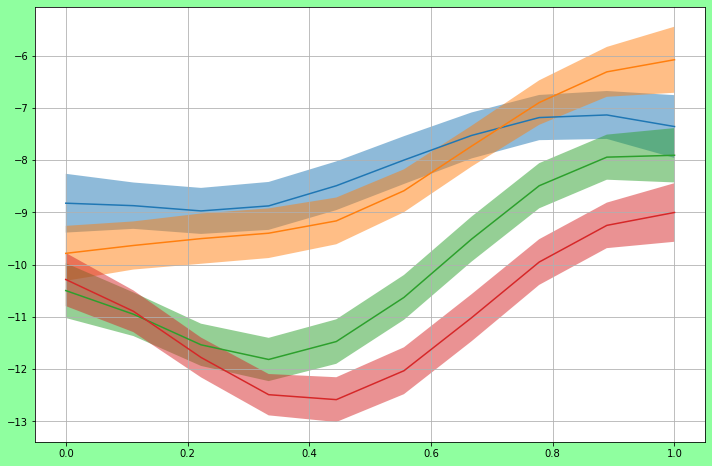

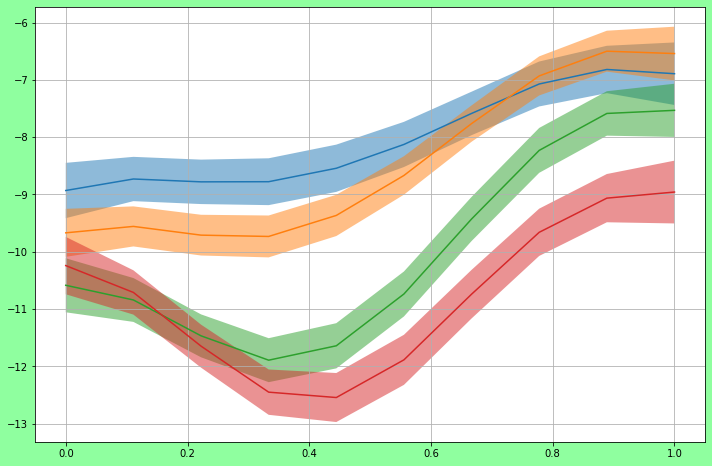

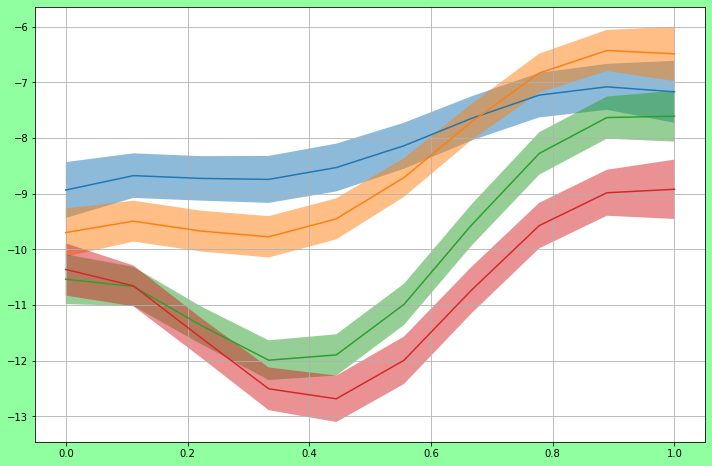

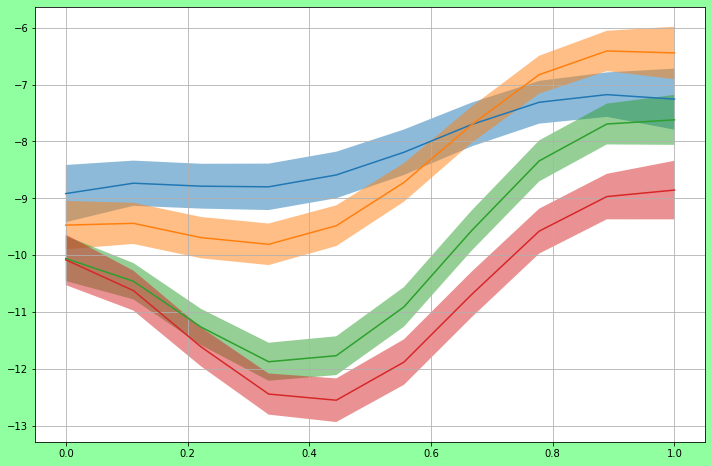

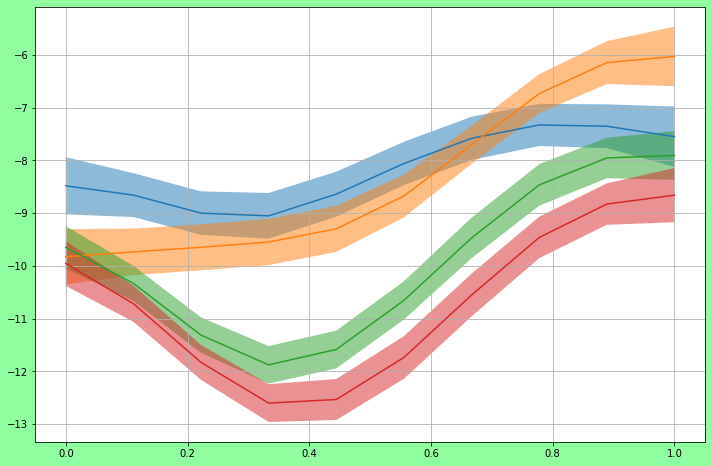

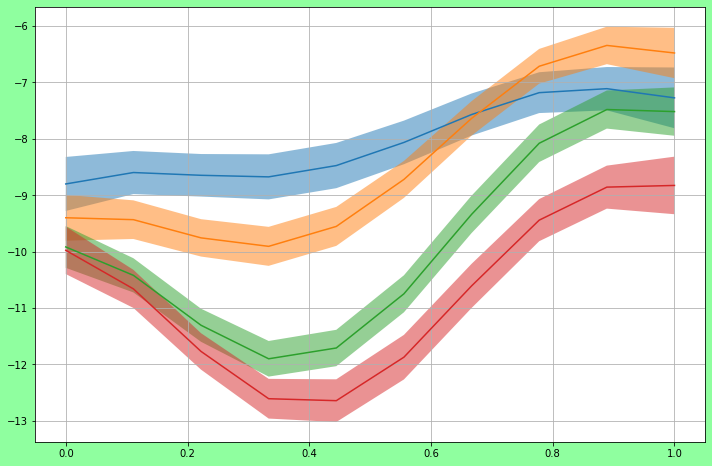

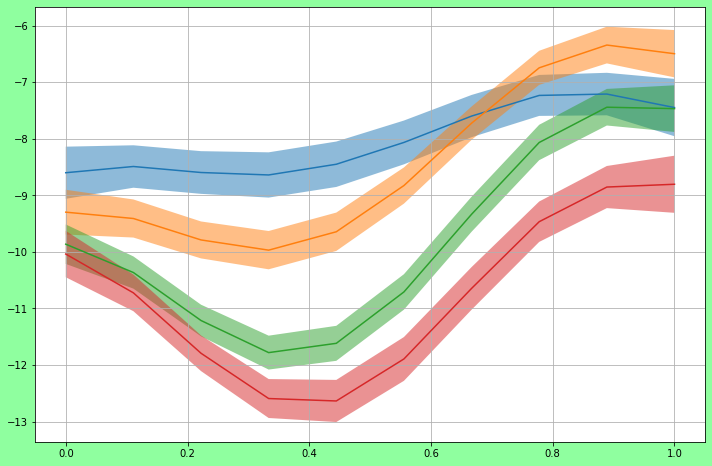

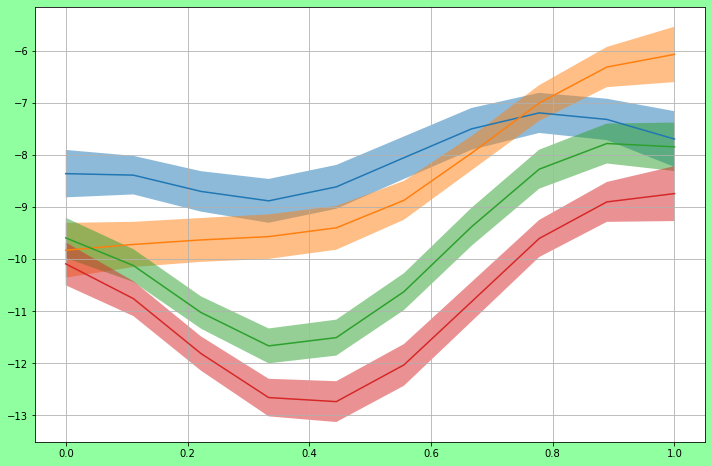

In [4]:
all_alternatives = train_X[:num_arms*num_contexts]
observations_per = 10

iterations = 10

for i in range(iterations):
    alternatives = torch.randint(
        0, all_alternatives.shape[0], (observations_per,), device=ckwargs["device"]
    )
    new_X = all_alternatives[alternatives]
    new_Y = ground_truth.evaluate_all()[alternatives]

    train_X = torch.cat([train_X, new_X], dim=0)
    train_Y = torch.cat([train_Y, new_Y], dim=0)

    lcegp = fit_lcegp(train_X, train_Y)

    plot_posterior(lcegp, arm_set, context_map)
    print(f"PCS estimate: {get_pcs(lcegp, arm_set, context_map)}")
    sleep(0.1)

Let's see what the training data is like, using the independent model

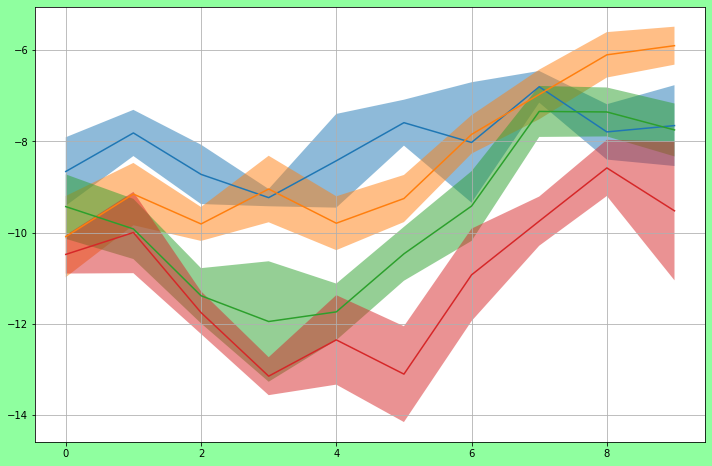

PCS estimate: 0.787109375


In [5]:
from contextual_rs.models.contextual_independent_model import ContextualIndependentModel

X_arms = train_X[:, :1]
X_contexts = train_X[:, 1:]
X_context_idx = torch.zeros(X_contexts.shape[0], 1, **ckwargs)
for i, context in enumerate(context_map):
    mask = X_contexts == context
    X_context_idx[mask] = i
X_idx = torch.cat([X_arms, X_context_idx], dim=-1)
context_idcs = torch.arange(0, num_contexts, **ckwargs).view(-1, 1)

indep_model = ContextualIndependentModel(X_idx, train_Y.squeeze(-1))
plot_posterior(indep_model, arm_set, context_idcs)
print(f"PCS estimate: {get_pcs(indep_model, arm_set, context_idcs)}")

The Independent model is doing significantly worse in the end. That is somewhat
unexpected, given the superior performance it demonstrated in the experiments.

Let's make this into a loop, run for multiple replications and see how the predictive
performances compare between the two models.

This is taking the selection mechanism out of the loop, which could potentially be the
culprit.

In [38]:
from typing import Tuple

def single_run(
    seed: int,
    iterations: int,
    num_arms: int = 4,
    num_contexts: int = 10,
    num_full_train: int = 3,
    observations_per: int = 10,
    num_tries: int = 1,
) -> Tuple[Tensor, Tensor]:
    torch.manual_seed(seed)
    arm_set = torch.arange(0, num_arms, **ckwargs).view(-1, 1)
    context_map = torch.linspace(0, 1, num_contexts, **ckwargs).view(-1, 1)

    ground_truth = GroundTruthModel(
        num_arms=num_arms, context_map=context_map, init_scale=20.0, observation_noise=1.5
    )

    train_X = (
        torch.cat(
            [
                arm_set.view(-1, 1, 1).expand(-1, num_contexts, -1),
                context_map.expand(num_arms, -1, -1),
            ],
            dim=-1,
        )
        .view(-1, 2)
        .repeat(num_full_train, 1)
    )
    train_Y = torch.cat(
        [ground_truth.evaluate_all() for _ in range(num_full_train)], dim=0
    )

    all_alternatives = train_X[:num_arms*num_contexts]
    context_idcs = torch.arange(0, num_contexts, **ckwargs).view(-1, 1)

    indep_pcs = torch.zeros(iterations, **ckwargs)
    lcegp_pcs = torch.zeros(iterations, **ckwargs)

    for i in range(iterations):
        if i % 10 == 0:
            print(f"Starting seed {seed}, iteration {i}")
        # data for independent model
        X_arms = train_X[:, :1]
        X_contexts = train_X[:, 1:]
        X_context_idx = torch.zeros(X_contexts.shape[0], 1, **ckwargs)
        for j, context in enumerate(context_map):
            mask = X_contexts == context
            X_context_idx[mask] = j
        X_idx = torch.cat([X_arms, X_context_idx], dim=-1)

        # fit models and get pcs
        lcegp = fit_lcegp(train_X, train_Y, num_tries=num_tries)
        indep_model = ContextualIndependentModel(X_idx, train_Y.squeeze(-1))

        indep_pcs[i] = get_pcs(indep_model, arm_set, context_idcs)
        lcegp_pcs[i] = get_pcs(lcegp, arm_set, context_map)

        # add new observations
        alternatives = torch.randint(
            0, all_alternatives.shape[0], (observations_per,), device=ckwargs["device"]
        )
        new_X = all_alternatives[alternatives]
        new_Y = ground_truth.evaluate_all()[alternatives]

        train_X = torch.cat([train_X, new_X], dim=0)
        train_Y = torch.cat([train_Y, new_Y], dim=0)
    return lcegp_pcs, indep_pcs


def multi_run(
    replications: int,
    iterations: int,
    **kwargs,
) -> Tuple[Tensor, Tensor]:
    indep_pcs = torch.zeros(replications, iterations, **ckwargs)
    lcegp_pcs = torch.zeros(replications, iterations, **ckwargs)
    for seed in range(replications):
        l_pcs, i_pcs = single_run(seed, iterations, **kwargs)
        indep_pcs[seed] = i_pcs
        lcegp_pcs[seed] = l_pcs
    return lcegp_pcs, indep_pcs


In [27]:
lcegp_pcs, indep_pcs = multi_run(10, 10)

Starting seed 0, iteration 0
Starting seed 0, iteration 5
Starting seed 1, iteration 0
Starting seed 1, iteration 5
Starting seed 2, iteration 0
Starting seed 2, iteration 5
Starting seed 3, iteration 0
Starting seed 3, iteration 5
Starting seed 4, iteration 0
Starting seed 4, iteration 5
Starting seed 5, iteration 0
Starting seed 5, iteration 5
Starting seed 6, iteration 0
Starting seed 6, iteration 5
Starting seed 7, iteration 0
Starting seed 7, iteration 5
Starting seed 8, iteration 0
Starting seed 8, iteration 5
Starting seed 9, iteration 0
Starting seed 9, iteration 5


In [31]:
def plot_pcs(lcegp_pcs: Tensor, indep_pcs: Tensor) -> None:
    fig = plt.figure(figsize=(12, 8))
    fig.patch.set_facecolor('xkcd:mint green')
    x = list(range(lcegp_pcs.shape[-1]))
    plt.plot(x, lcegp_pcs.mean(dim=0), label="lcegp")
    plt.fill_between(
        x,
        lcegp_pcs.mean(dim=0) - lcegp_pcs.std(dim=0),
        lcegp_pcs.mean(dim=0) + lcegp_pcs.std(dim=0),
        alpha=0.5
    )
    plt.plot(x, indep_pcs.mean(dim=0), label="indep")
    plt.fill_between(
        x,
        indep_pcs.mean(dim=0) - indep_pcs.std(dim=0),
        indep_pcs.mean(dim=0) + indep_pcs.std(dim=0),
        alpha=0.5
    )
    plt.grid()
    plt.legend()
    plt.show()

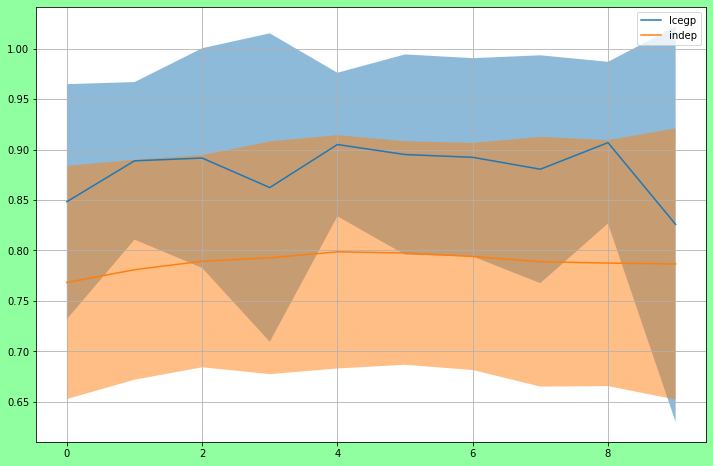

In [32]:
plot_pcs(lcegp_pcs, indep_pcs)

Starting seed 0, iteration 0
Starting seed 0, iteration 5
Starting seed 0, iteration 10
Starting seed 0, iteration 15
Starting seed 0, iteration 20
Starting seed 0, iteration 25
Starting seed 1, iteration 0
Starting seed 1, iteration 5
Starting seed 1, iteration 10
Starting seed 1, iteration 15
Starting seed 1, iteration 20
Starting seed 1, iteration 25
Starting seed 2, iteration 0
Starting seed 2, iteration 5
Starting seed 2, iteration 10
Starting seed 2, iteration 15
Starting seed 2, iteration 20
Starting seed 2, iteration 25
Starting seed 3, iteration 0
Starting seed 3, iteration 5
Starting seed 3, iteration 10
Starting seed 3, iteration 15
Starting seed 3, iteration 20
Starting seed 3, iteration 25
Starting seed 4, iteration 0
Starting seed 4, iteration 5
Starting seed 4, iteration 10
Starting seed 4, iteration 15
Starting seed 4, iteration 20
Starting seed 4, iteration 25
Starting seed 5, iteration 0
Starting seed 5, iteration 5
Starting seed 5, iteration 10
Starting seed 5, itera

/home/saitcakmak/anaconda3/envs/contextual_rs/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


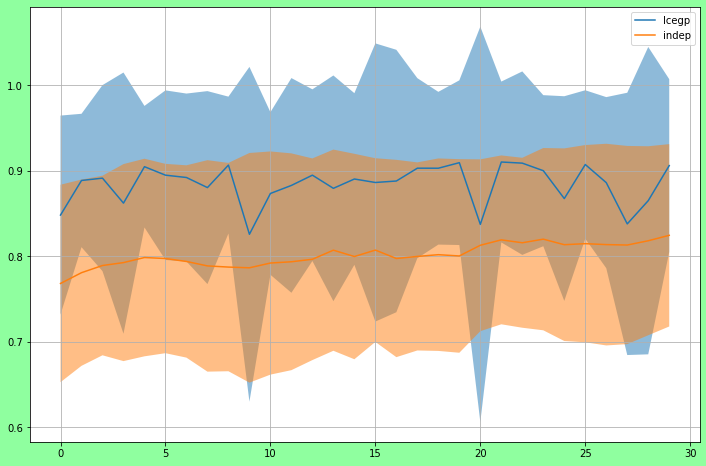

In [33]:
lcegp_pcs, indep_pcs = multi_run(10, 30)

plot_pcs(lcegp_pcs, indep_pcs)

Starting seed 0, iteration 0
Starting seed 0, iteration 10
Starting seed 0, iteration 20
Starting seed 0, iteration 30
Starting seed 0, iteration 40
Starting seed 0, iteration 50
Starting seed 0, iteration 60
Starting seed 0, iteration 70
Starting seed 0, iteration 80
Starting seed 0, iteration 90
Starting seed 1, iteration 0
Starting seed 1, iteration 10
Starting seed 1, iteration 20
Starting seed 1, iteration 30
Starting seed 1, iteration 40
Starting seed 1, iteration 50
Starting seed 1, iteration 60
Starting seed 1, iteration 70
Starting seed 1, iteration 80
Starting seed 1, iteration 90
Starting seed 2, iteration 0
Starting seed 2, iteration 10
Starting seed 2, iteration 20
Starting seed 2, iteration 30
Starting seed 2, iteration 40
Starting seed 2, iteration 50
Starting seed 2, iteration 60
Starting seed 2, iteration 70
Starting seed 2, iteration 80
Starting seed 2, iteration 90
Starting seed 3, iteration 0
Starting seed 3, iteration 10
Starting seed 3, iteration 20
Starting seed 

/home/saitcakmak/anaconda3/envs/contextual_rs/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:51: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


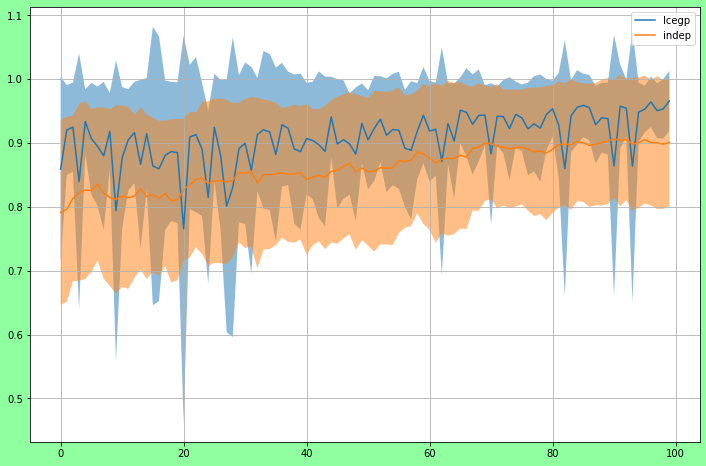

In [36]:
lcegp_pcs, indep_pcs = multi_run(5, 100)

plot_pcs(lcegp_pcs, indep_pcs)

Let's take a closer look to LCEGP here by plotting each replication.

These spikes simply should not happen in an ideal world. Latest spikes are after
hundreds of total observations.

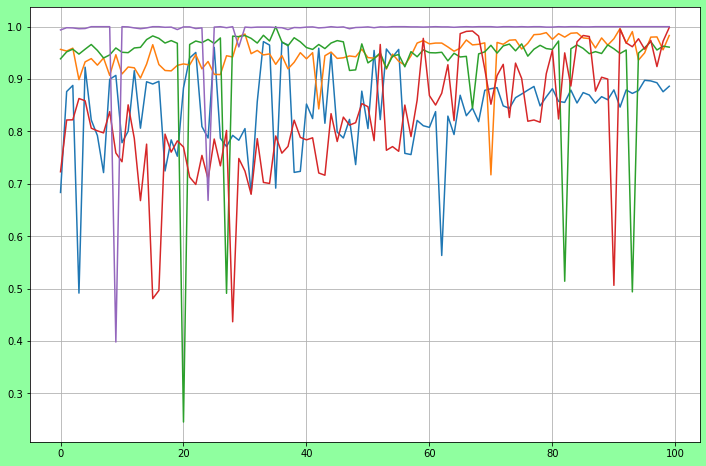

In [37]:
fig = plt.figure(figsize=(12, 8))
fig.patch.set_facecolor('xkcd:mint green')
for pcs in lcegp_pcs:
    plt.plot(pcs)
plt.grid()
plt.show()

How does it change when we have multiple fit tries?

Starting seed 0, iteration 0
Starting seed 0, iteration 10
Starting seed 1, iteration 0
Starting seed 1, iteration 10
Starting seed 2, iteration 0
Starting seed 2, iteration 10
Starting seed 3, iteration 0
Starting seed 3, iteration 10
Starting seed 4, iteration 0
Starting seed 4, iteration 10


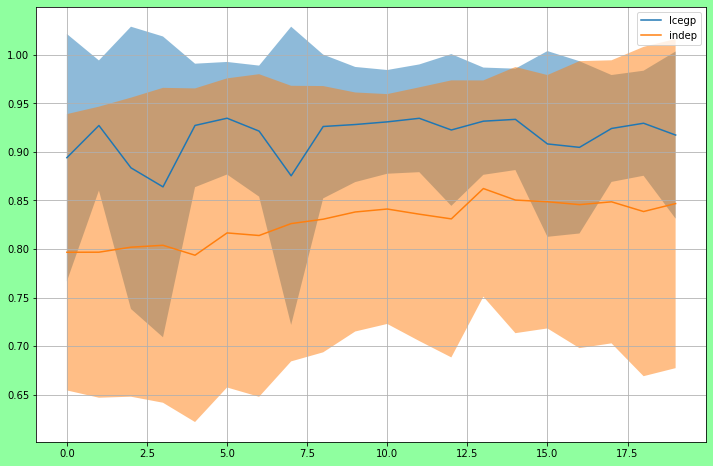

In [41]:
lcegp_pcs, indep_pcs = multi_run(5, 20, num_tries=5)

plot_pcs(lcegp_pcs, indep_pcs)